This Notebook is part of The Study of **Research Project 1** By **Mehedi Hasan Emon**

## Preprocessing

Mount Google Drive to access the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install required packages

In [ ]:
!pip install datasets
!pip install umap-learn
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

Load and create the dataframe

In [ ]:
with open("/content/drive/MyDrive/Data/data.csv", "r") as file:
    reader = csv.reader(file)
    data = list(reader)

header = data[0]
data = data[1:]

# Convert to DataFrame
df = pd.DataFrame(data, columns=header)

# Check the class distribution
print("Original class distribution:\n", df['label'].value_counts())

Original class distribution:
 label
0    25
2     9
3     7
6     6
1     5
5     2
7     2
4     1
Name: count, dtype: int64


In [ ]:
# Create a label map for easy interpretation
label_map = {0: "elaboration", 1: "background", 2: "contrast", 3: "narration", 4: "concession", 5: "restatement", 6: "cause-effect", 7: "joint"}

df["label"] = pd.to_numeric(df["label"], errors='coerce').astype('Int64')
df["label_name"] = df["label"].map(label_map)
df.head()

,edu_1,edu_2,label,label_name
0,England pace bowler Jofra Archer could play in...,"will not play test cricket until 2025,",2,contrast
1,England pace bowler Jofra Archer could play in...,according to England managing director Rob Key.,1,background
2,England pace bowler Jofra Archer could play in...,The 29-year-old has not played for England in ...,0,elaboration
3,Archer's England career has been plagued by in...,and he has not played a test match since the t...,0,elaboration
4,Jofra's been out at Sussex's pre-season in Ind...,He bowled really well.,0,elaboration


Original Class distribution

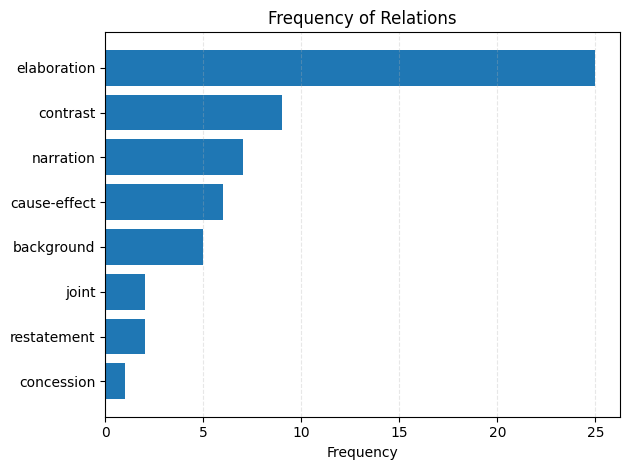

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the values and index for the bar plot
values = df["label_name"].value_counts(ascending=True).values
index = df["label_name"].value_counts(ascending=True).index

plt.barh(np.arange(len(index)), values) # Use numerical indices for y-axis

plt.title("Frequency of Relations")
plt.xlabel("Frequency")
#plt.ylabel("Relation Type", fontsize=12) #Remove ylabel for removing label_name
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Set y-axis tick labels to the original column names
plt.yticks(np.arange(len(index)), index)

# df["label_name"].value_counts(ascending=True).plot.barh()
# plt.title("Frequency of Relations")
# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('frequency_of_relations.png')
plt.show()

As we can see our data is highly Imbalance so we need to balance it in order to get better result with our models. we can choose many approch but here we follow the randomly oversample the minority class.

In [ ]:
# Identify the maximum class size
max_size = df['label'].value_counts().max()

# Perform oversampling
balanced_df = pd.DataFrame()
for label in df['label'].unique():
    class_subset = df[df['label'] == label]
    class_oversampled = resample(class_subset, replace=True, n_samples=max_size, random_state=42)
    balanced_df = pd.concat([balanced_df, class_oversampled])

balanced_df['label'] = pd.to_numeric(balanced_df['label'], errors='coerce').astype(int)
# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Balanced class distribution:\n", balanced_df['label'].value_counts())

Balanced class distribution:
 label
3    25
2    25
1    25
6    25
5    25
4    25
0    25
7    25
Name: count, dtype: int64


Now convert balance df into Huggingface datasets as Train, Test and Validation split. where train split contain the 80% of the data test 20% and between 80% of train data we took 25% as validation data set.

In [ ]:
from collections import Counter
from datasets import Dataset, DatasetDict, load_dataset

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the dataset into train, validation, and test sets
split_dataset = train_test_split(balanced_df,test_size=0.2, random_state=42)
train_data, test_data = split_dataset
train_data, validation_data = train_test_split(train_data, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Combine into a DatasetDict
rhetorical_data = DatasetDict({
    'train': Dataset.from_pandas(train_data),
    'validation': Dataset.from_pandas(validation_data),
    'test': Dataset.from_pandas(test_data)
})

# Check the resulting splits
print(rhetorical_data)


DatasetDict({
    train: Dataset({
        features: ['edu_1', 'edu_2', 'label', 'label_name', '__index_level_0__'],
        num_rows: 120
    })
    validation: Dataset({
        features: ['edu_1', 'edu_2', 'label', 'label_name', '__index_level_0__'],
        num_rows: 40
    })
    test: Dataset({
        features: ['edu_1', 'edu_2', 'label', 'label_name', '__index_level_0__'],
        num_rows: 40
    })
})


Overview of Train split of datasets

In [ ]:
rhetorical_data.set_format(type="pandas")
rhetorical_data['train'][:]
#save into dummy_df for further analysis
dummy_df = rhetorical_data['train'][:]
dummy_df.head()

,edu_1,edu_2,label,label_name,__index_level_0__
0,After lengthy conversations with my family and...,I feel it is now time for me to return home an...,6,cause-effect,42
1,Sri Lanka head coach Chris Silverwood has resi...,the country's cricket board said on Thursday.,1,background,157
2,The team are set to depart for Australia on Ju...,"Following the red-ball format, Bangladesh A wi...",3,narration,155
3,India have yet to lose a match at the 20-over ...,but the only Test side that England have defea...,2,contrast,3
4,"Maxwell, who will be key for Australia at the ...",was one of the first cricketers to recognise m...,1,background,99


As, Transformer based models have a maximum context size, For example **BERT** & **DistilBERT** both has 512 max tokens. it means we can't process input more than the max tokens, so that's why we have to look on our data that how much words we have on our disousre units. here we can see that our both edu1 & edu2 combine have max 30 words per units.

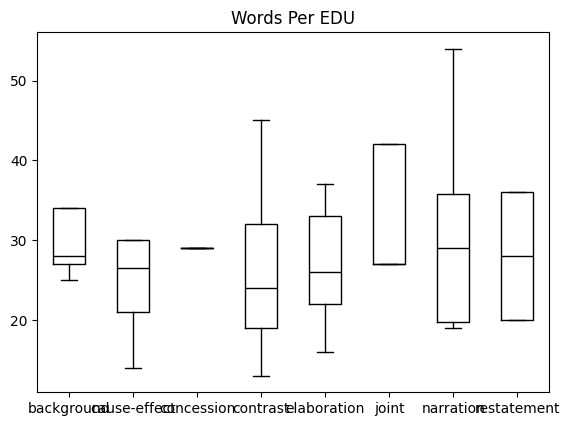

In [ ]:
dummy_df["Words Per EDU"] = dummy_df["edu_1"].str.split().apply(len) + dummy_df["edu_2"].str.split().apply(len)
dummy_df.boxplot("Words Per EDU", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

now we need to change our rst data from pandas format as we have to train our model.

In [ ]:
rhetorical_data.reset_format()

## Load Model

now we will load our model using `AutoModel` class.

In [ ]:
from transformers import AutoModel, AutoTokenizer

#switch different model
#bert-base-uncased #distilbert-base-uncased
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

#### Tokenize function

Insted of using `BertTokenizer` or `DistilBertTokenizer` we use `AutoTokenizer` Class that means it will load the token from the model that define in `model_ckpt`. Here point to be noted that we will process our both discourse units at the same time.

In [ ]:
# Define the tokenize function
def tokenize(batch):
    return tokenizer(batch["edu_1"], batch["edu_2"], padding=True, truncation=True)

Testing the tokenize function with 1 data from train set.

In [ ]:
print(tokenize(rhetorical_data["train"][:1]))

{'input_ids': [[101, 2044, 12401, 11450, 2007, 2026, 2155, 1998, 2007, 1037, 3082, 2540, 1010, 102, 1045, 2514, 2009, 2003, 2085, 2051, 2005, 2033, 2000, 2709, 2188, 1998, 5247, 2070, 3737, 2051, 2362, 1010, 3165, 3702, 2056, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Tokenizing the whole dataset and saved as encoded data.

In [ ]:
rhetorical_data_encoded = rhetorical_data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

**Note**: There is 2 more column added as `input_ids` & `attention_mask`, The Input ids contain unique numerical identifier for eatch token and the attention mask is a way to determind which token should be focus.

In [ ]:
print(rhetorical_data_encoded["train"].column_names)

['edu_1', 'edu_2', 'label', 'label_name', '__index_level_0__', 'input_ids', 'attention_mask']


Extracting the last hidden states

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

As model uses tensors as inputs, so we need to convert the
`input_ids` & `attention_mask` columns to the "torch" format, as follows:

In [ ]:
rhetorical_data_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

Apply the hidden states with our encoded datasets.

In [ ]:
rhetorical_data_hidden = rhetorical_data_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Now we will see a new column as `hidden_state`

In [ ]:
rhetorical_data_hidden["train"].column_names

['edu_1',
 'edu_2',
 'label',
 'label_name',
 '__index_level_0__',
 'input_ids',
 'attention_mask',
 'hidden_state']

#### Feature matrix

Now we have all the necessary information to train a classifier. we will use `hidden_state` as Input Features and the labels as target and create the corresponding arrays as Scikit-learn format.

In [ ]:
import numpy as np

X_train = np.array(rhetorical_data_hidden["train"]["hidden_state"])
X_valid = np.array(rhetorical_data_hidden["validation"]["hidden_state"])
y_train = np.array(rhetorical_data_hidden["train"]["label"])
y_valid = np.array(rhetorical_data_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((120, 768), (40, 768))

#### Visualizing the training set

The result is an array with the same number of training samples, but withonly 2 features instead of the 768 we started with!

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,-0.567541,16.344809,6
1,16.844749,13.536299,1
2,11.201170,-6.888518,3
3,14.217577,17.202913,2
4,17.037786,12.915193,1


Now we will investigate the data a little bit further and plot the density of points for each category separately:

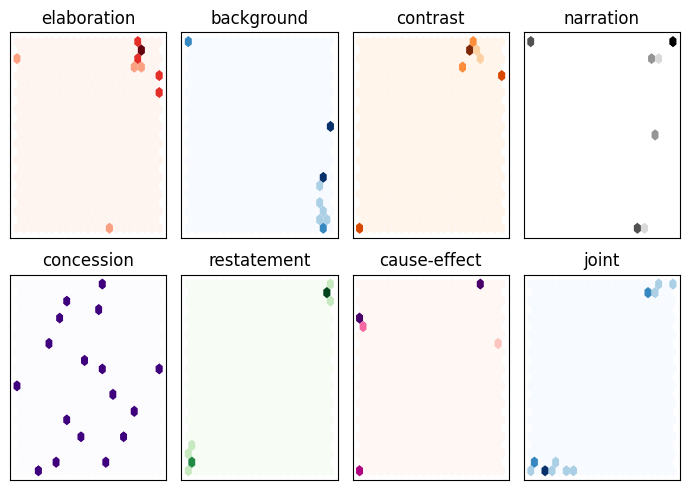

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Reds", "Blues", "Oranges", "Greys", "Purples", "Greens", "RdPu", "Blues"]
labels = label_map.values()

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Training a simple classifier

Now we will use hidden states to train a logistic regression model with Scikit-learn.

In [ ]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.9

Our simple classifier loaded with the embeddings from transformer based model. it appear that our model is better than random with the **accuracy of 90%.**

#### confusion matrix

Let's have further look on the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

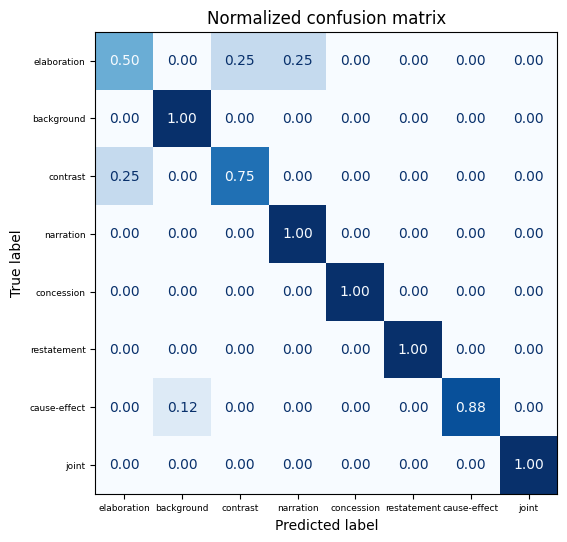

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    # Get unique labels present in y_true and y_preds
    unique_labels = np.unique(np.concatenate((y_true, y_preds)))

    # Filter labels to only include those present in the data
    display_labels = [label for i, label in enumerate(labels) if i in unique_labels]

    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels) # Use filtered labels
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), fontsize=6.5)
    disp.ax_.set_yticklabels(disp.ax_.get_yticklabels(), fontsize=6.5)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, list(labels)) # Convert labels to a list

### Fine-Tuning Transformers

Now, we will fine tune the transformers model such as BERT & DistilBERT, Here we use the `AutoModelForSequenceClassification` insted of `AutoModel` As it added a classification head on top of the pretrained model outputs.

In [ ]:
from transformers import AutoModelForSequenceClassification

# number of rst labels
num_labels = 8
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defining the performance metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### Training the model

As we have our datasets & performance metrics now we have to setup our Hugging Face account to saved our fine-tuned model & setup the hyperparameters for the training run.

In [ ]:
with open('/content/drive/MyDrive/Data/huggingface_token.txt', 'r') as f:
    huggingface_token = f.read().strip()

In [ ]:
from huggingface_hub import login

# login into huggingface hub
login(token=huggingface_token)

To setup the training parameters, here we use the
`TrainingArguments` class. This class stores a lot of information and gives us more control over the training and evaluation.

Here we can adjust the `batch_size`, `num_train_epochs`, `learning_rate` to load the best model at the end of the training run.

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = max(1, len(rhetorical_data_encoded["train"]) // batch_size) # Modified line
model_name = f"{model_ckpt}-finetuned-rst-sports"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=20,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Now we can fine tune our model with the `Trainer` class.

In [ ]:
with open('/content/drive/MyDrive/Data/wandb.txt', 'r') as f:
    wandb_token = f.read().strip()

In [ ]:
import wandb
wandb.login(key=wandb_token)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mhemon02 (mhemon02-ruhr-university-bochum) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=rhetorical_data_encoded["train"],
                  eval_dataset=rhetorical_data_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

<ipython-input-33-34963e65210c>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.058800,2.046214,0.125000,0.030488
2,2.019800,2.015159,0.150000,0.053472
3,2.001600,1.981743,0.250000,0.202885
4,1.944800,1.944903,0.375000,0.343507
5,1.905100,1.902944,0.400000,0.379467
6,1.841400,1.857301,0.400000,0.356944
7,1.808400,1.811876,0.425000,0.400054
8,1.752300,1.766307,0.650000,0.644365
9,1.698300,1.720403,0.750000,0.742006
10,1.668600,1.677277,0.750000,0.742006


In [ ]:
preds_output = trainer.predict(rhetorical_data_encoded["validation"])

In [ ]:
#distilbert
preds_output.metrics

{'test_loss': 1.4581642150878906,
 'test_accuracy': 0.85,
 'test_f1': 0.8351388888888888,
 'test_runtime': 0.1112,
 'test_samples_per_second': 359.828,
 'test_steps_per_second': 8.996}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

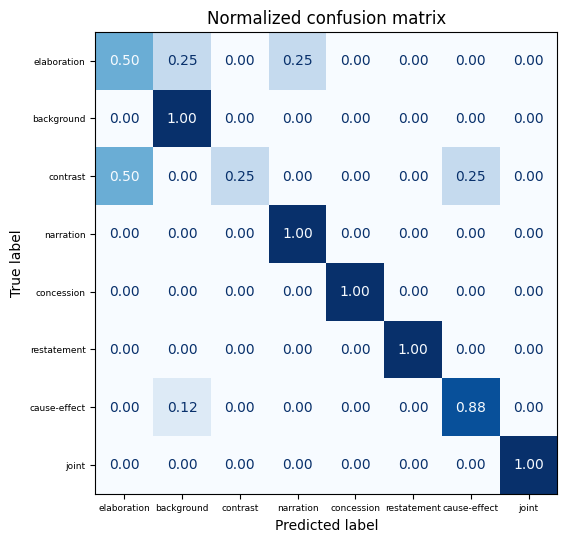

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

### Error analysis

To investigate our model’s predictions a little bit further. we can follow a powerful technique is to sort the validation samples by the model loss.

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
rhetorical_data_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
rhetorical_data_encoded["validation"] = rhetorical_data_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [ ]:
rhetorical_data_encoded['validation'].column_names

['edu_1',
 'edu_2',
 'label',
 'label_name',
 '__index_level_0__',
 'input_ids',
 'attention_mask',
 'loss',
 'predicted_label']

In [ ]:
rhetorical_data_encoded.set_format("pandas")
cols = ["edu_1", "edu_2", "label", "predicted_label", "loss"]
df_test = rhetorical_data_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].map(label_map)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .map(label_map))

In [ ]:
df_test.sort_values("loss", ascending=False).head(5)

,edu_1,edu_2,label,predicted_label,loss
20,Sri Lanka head coach Chris Silverwood has resi...,"in order to spend more time with his family,",cause-effect,background,2.196362
8,He'll hopefully play the Pakistan T20 series (...,but it's all fingers crossed with Jofra at the...,contrast,elaboration,1.963699
10,Australia's Glenn Maxwell will take an indefin...,after struggling for form with Royal Challenge...,elaboration,narration,1.949952
19,Rain delayed the toss in the T20 World Cup sem...,but the pitch and square remained fully covered.,contrast,elaboration,1.938233
21,for the team management to work out a differen...,but they opted for one that did not work.,contrast,cause-effect,1.849523


#### Reference

Tunstall, Lewis, Leandro von Werra, and Thomas Wolf. 2022. Natural Language Processing with Transformers. Revised ed. O'Reilly Media.